(104, 360, 360)
50 50 50


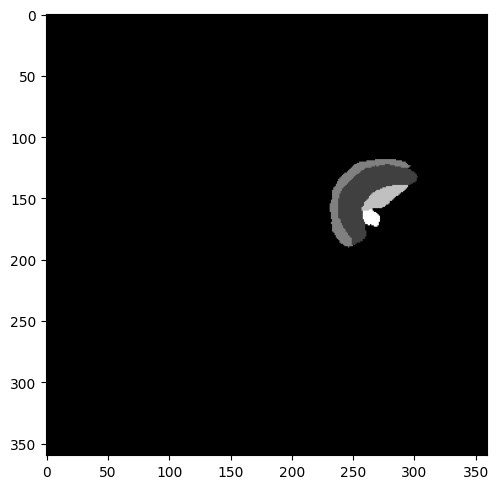

In [2]:
# Methods figure
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass 
import nibabel as nib
import numpy as np

# seg_file = nib.load('./dataset/labels/'
#                'sub-023_ses01_acqT2wCSpine_run1_T2w_labels.nii.gz')
# seg_file = nib.load('./dataset/images/'
#                'sub-023_ses-01_acq-T2wCSpine_run-1_T2w.nii.gz')
# seg_file = nib.load('./predictions/BeLong_registered_T1w/tta/NormSeg_1000e_unregistered_crop/400/'
#                     'sub-023_ses-02_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing.nii.gz')
# seg_file = nib.load('./predictions/BeLong_registered_T1w/NormSeg_1000e_unregistered_crop/'
#                     'sub-023_ses-02_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing.nii.gz')
# seg_file = nib.load('./4Inference/BeLong/T1w/labels/20230317_new_seg_JLF_Labels.nii.gz')
seg_file = nib.load('./4Inference/BeLong/T1w/case3-lessLabel/labels/'
                    'sub-011_ses-01_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing.nii.gz')
seg = seg_file.get_fdata()

x, y, z = 50, 50, 50
print(seg.shape)
print(x, y, z)
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(np.rot90(seg[40,:,:]), cmap='gray')

plt.tight_layout()

In [4]:
# Methods figure
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass 
import nibabel as nib
import numpy as np


seg_file = nib.load('./4Inference/BeLong/T2w_deformable/images/'
                    'sub-014_ses-02_acq-T2wCSpine_run-1_T2w_Warped.nii.gz')
seg = seg_file.get_fdata()
print(seg.shape)
# x, y, z = 50, 50, 50
# print(seg.shape)
# print(x, y, z)
# fig = plt.figure(figsize=(30,5))
# ax1 = fig.add_subplot(1,1,1)
# ax1.imshow(np.rot90(seg[40,:,:]), cmap='gray')

# plt.tight_layout()

(64, 320, 320)


In [5]:
seg_file = nib.load('./4Inference/BeLong/T2w_deformable/labels/'
                    '20230317_new_seg_JLF_Labels.nii.gz')
seg = seg_file.get_fdata()
print(seg.shape)

(104, 360, 360)


In [7]:
seg_file = nib.load('./4Inference/BeLong/T1w/images/'
                    'sub-011_ses-01_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing.nii.gz')
seg = seg_file.get_fdata()
print(seg.shape)

(104, 360, 360)


# Generate volume with only one labeled slice

(104, 360, 360)
50 50 50


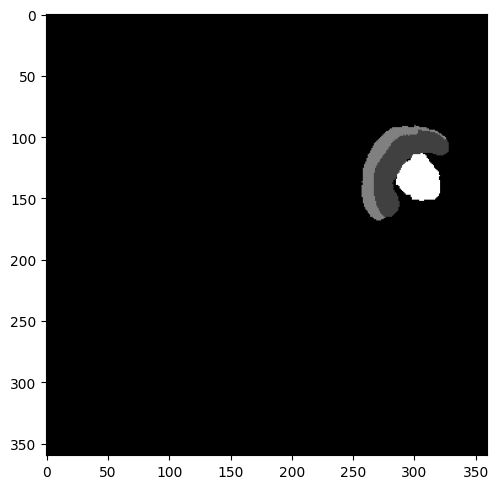

In [35]:
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass 
import nibabel as nib
import numpy as np


seg_file = nib.load('/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/4Inference/BeLong/T1w/case3/labels/'
                    'sub-016_ses-02_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing.nii.gz')
seg = seg_file.get_fdata()

x, y, z = 50, 50, 50
print(seg.shape)
print(x, y, z)
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(np.rot90(seg[55,:,:]), cmap='gray')

plt.tight_layout()


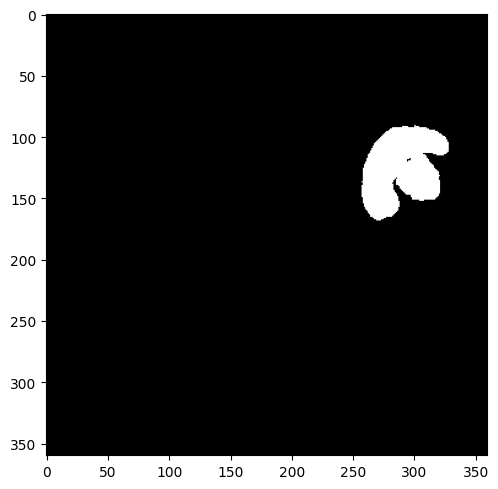

In [36]:
# All tongue
seg_tmp = np.zeros(seg.shape)
seg_tmp[seg!=0] = 1

fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(np.rot90(seg_tmp[55,:,:]), cmap='gray')

plt.tight_layout()

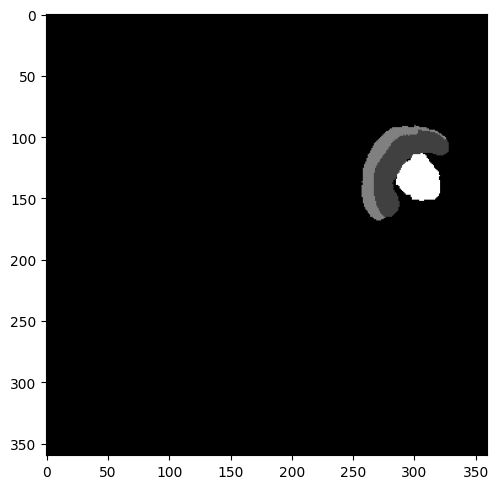

In [37]:
# Few slices
seg_tmp = np.zeros(seg.shape)
seg_tmp[55:65:,:,:]=seg[55:65,:,:]

fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(np.rot90(seg_tmp[55,:,:]), cmap='gray')

plt.tight_layout()

In [38]:
final_img = nib.Nifti1Image(seg_tmp, seg_file.affine)
nib.save(final_img, './sub-016_ses-02_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing.nii.gz')

# Image intensity changes

In [1]:
from monai.networks.nets import DynUNet
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.data import Dataset, DataLoader, list_data_collate
from glob import glob
from utils.transforms import get_train_transforms, get_val_transforms, get_eval_post_transforms
from utils.training import train_NormSeg, train_segmenter, test_NormSeg, test_segmenter
from utils.model import Normalizer
from utils.plotting import input_check
import sys
import os
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('./')


def dataloader(path, SPATIAL_SIZE, LABELS):
    # Data directory
    dataDir_img = path + 'images/'
    dataDir_seg = path + 'labels/'

    images = sorted(glob(os.path.join(dataDir_img, '*.nii.gz')))
    segs = sorted(glob(os.path.join(dataDir_seg, '*.nii.gz')))

    # Data prep
    train_files = [
        {'image': img, "label": seg} for img, seg in zip(images[:12], segs[:12])
    ]
    val_files = [
        {'image': img, "label": seg} for img, seg in zip(images[12:], segs[12:])
    ]

    # Dataloader
    train_ds = Dataset(
        data=train_files, transform=get_val_transforms(SPATIAL_SIZE, LABELS))
    train_ds_loader = DataLoader(train_ds, batch_size=1, shuffle=False,
                                 num_workers=2, collate_fn=list_data_collate,
                                 pin_memory=torch.cuda.is_available())

    val_ds = Dataset(
        data=val_files, transform=get_val_transforms(SPATIAL_SIZE, LABELS))
    val_ds_loader = DataLoader(val_ds, batch_size=1, shuffle=False,
                               num_workers=2, collate_fn=list_data_collate,)

    return train_ds_loader, val_ds_loader

SPATIAL_SIZE = [64, 128, 128]
LABELS = {
        "vertical": 1,
        "superior longitudinal": 2,
        "inferior longitudinal": 3,
        "genioglossus": 4,
        "hyoglossus": 5,
        "background": 0,
    }
CHANNELS = 1
dataDir = './dataset/'
modelsDir = './models/'
condition = '1000e_unregistered_crop'
norm_model = Normalizer()
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'normalization_model_' + condition + '.pt')))

train_loader, val_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [14]:
# dict(norm_model.named_parameters())['act2.sigma']

In [3]:
def generate_dist_dict(data_loader):
    distributions_orig = {'label':[],'intensity':[], 'participant':[]}
    distributions_norm = {'label':[],'intensity':[], 'participant':[]}

    with torch.no_grad():
        for batch_idx, data in enumerate(data_loader):
            norm_model.to(device)

            input_img = data['image'].to(device)
            norm_input = norm_model(input_img)

            nlabels = torch.unique(data['label'].flatten())
            voxels = 0
            for i in range(len(nlabels)):
                input_img_flat = input_img.flatten()
                norm_input_flat = norm_input.flatten()
                labels_flat = data['label'].flatten()

                distributions_orig['label'].extend(labels_flat[labels_flat==i].tolist())
                distributions_norm['label'].extend(labels_flat[labels_flat==i].tolist())

                distributions_orig['intensity'].extend(input_img_flat[labels_flat==i].tolist())
                distributions_norm['intensity'].extend(norm_input_flat[labels_flat==i].tolist())

                voxels += len(labels_flat[labels_flat==i])
            distributions_orig['participant'].extend([str(batch_idx)]*voxels)
            distributions_norm['participant'].extend([str(batch_idx)]*voxels)
    return pd.DataFrame(distributions_orig), pd.DataFrame(distributions_norm)

def distributions_plot(dataFrame):
    plot = sns.FacetGrid(dataFrame,col='label', row='participant', hue='label')
    plot.map(sns.kdeplot, 'intensity', fill=True)
    plt.xlim(-1,3)
    plt.ylim(0,5)

## BeLong - training data

In [4]:
dataFrame_orig, dataFrame_norm = generate_dist_dict(train_loader)

In [11]:
import numpy as np
np.max(dataFrame_orig.intensity)

6.471607685089111

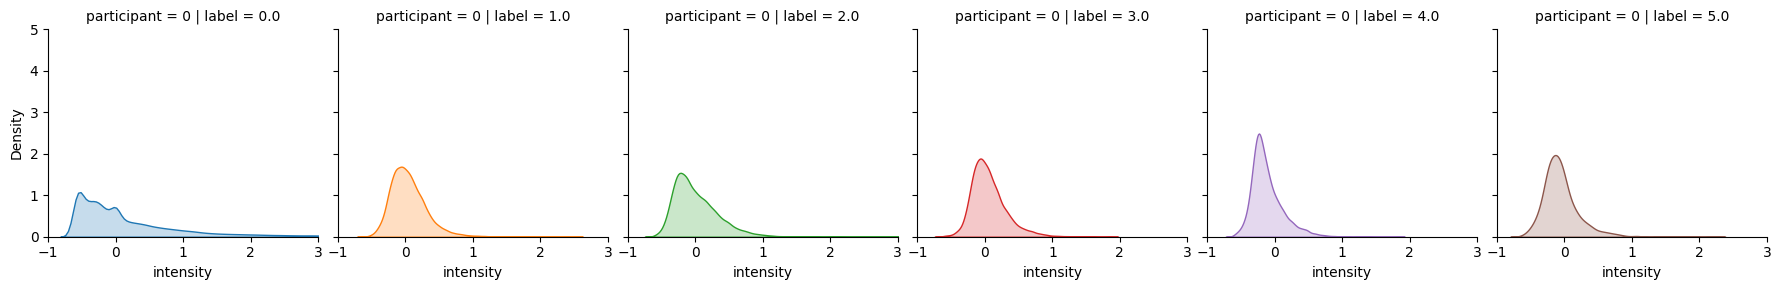

In [5]:
distributions_plot(dataFrame_orig[dataFrame_orig['participant']==str(0)])

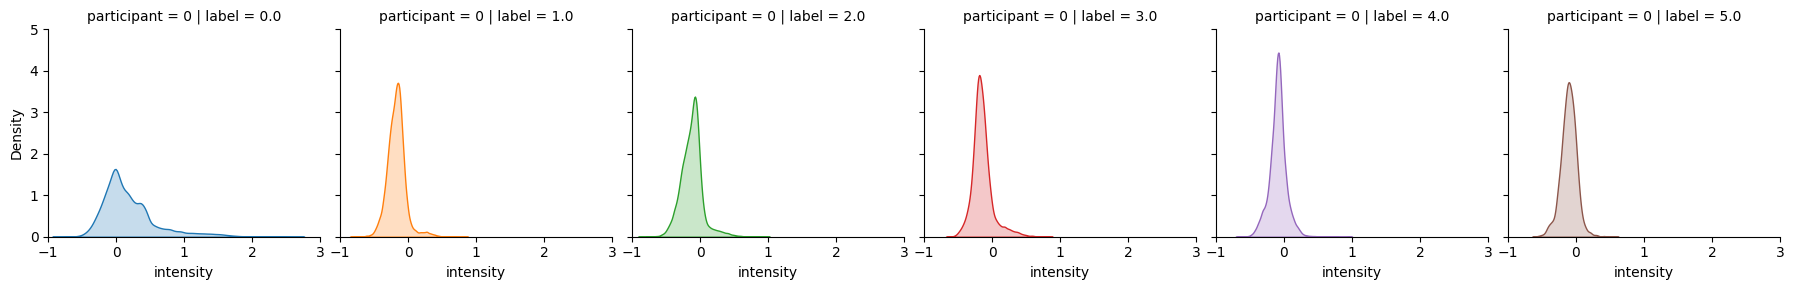

In [6]:
distributions_plot(dataFrame_norm[dataFrame_orig['participant']==str(0)])

## EATT - T1w

In [7]:
def dataloader(path, SPATIAL_SIZE, LABELS, sub_ID):
    # Data directory
    dataDir_img = path + 'images/'
    dataDir_seg = path + 'labels/'

    images = sorted(glob(os.path.join(dataDir_img, str(sub_ID) + '*')))
    segs = sorted(glob(os.path.join(dataDir_seg, '*.nii.gz')))
    
    segs = segs * len(images)

    # Data prep
    train_files = [
        {'image': img, "label": seg} for img, seg in zip(images[:], segs[:])
    ]

    # Dataloader
    train_ds = Dataset(
        data=train_files, transform=get_val_transforms(SPATIAL_SIZE, LABELS))
    train_ds_loader = DataLoader(train_ds, batch_size=1, shuffle=False,
                                 num_workers=2, collate_fn=list_data_collate,
                                 pin_memory=torch.cuda.is_available())

    return train_ds_loader

### After tta

In [18]:
dataDir = './4Inference/EATT/T1w/'
modelsDir = './models/tta/EATT_T1w/'
condition = '1000e_unregistered_crop'

norm_model = Normalizer()
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'sub-057_ses-01_acq-MP2Ragewip900D2018UNIDEN_T1w_reg_to_BeLong_template_Warped_correct_spacing_tta_400e_normalization_model_' + condition + '.pt')))

train_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS, 'sub-057_ses-01_acq')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

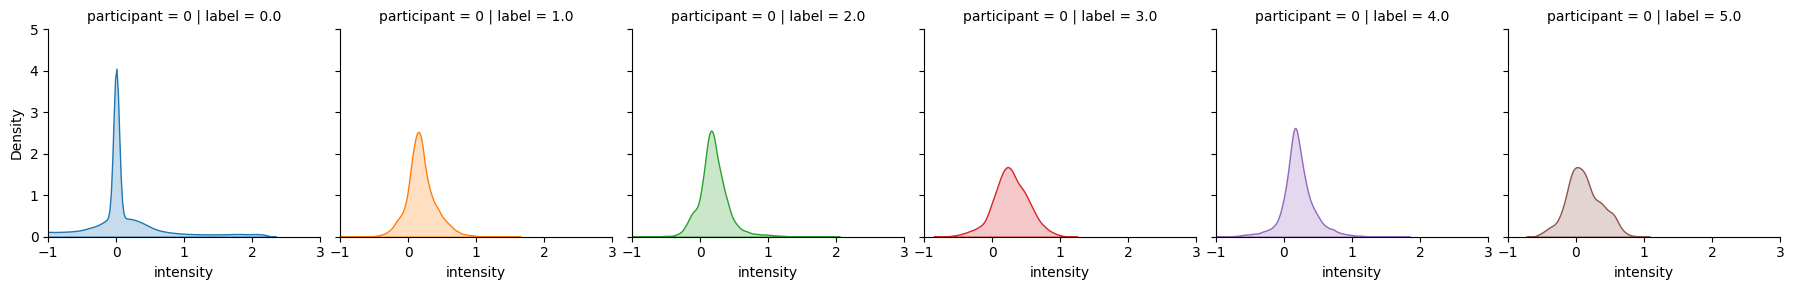

In [19]:
dataFrame_orig, dataFrame_norm = generate_dist_dict(train_loader)
distributions_plot(dataFrame_orig)

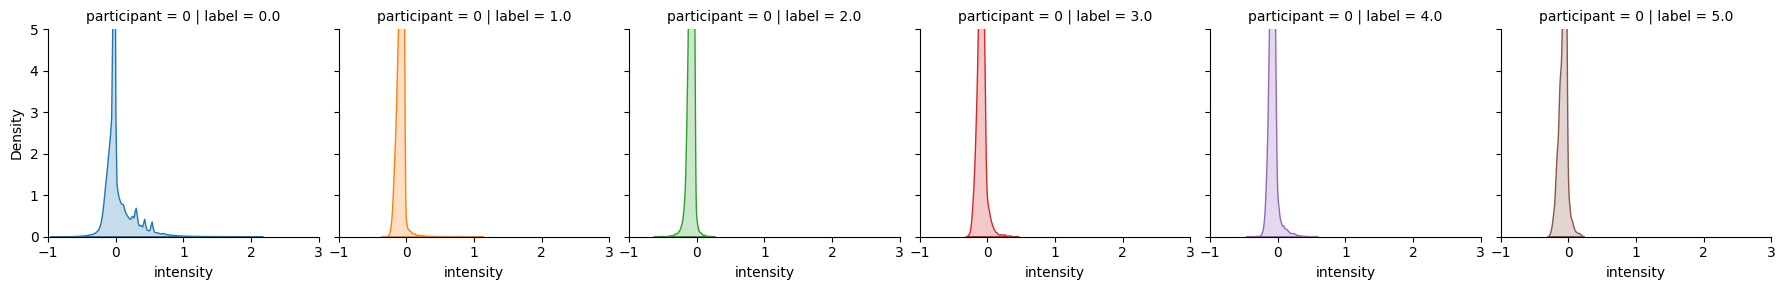

In [20]:
distributions_plot(dataFrame_norm[dataFrame_norm['participant']==str(0)])

### Before TTA

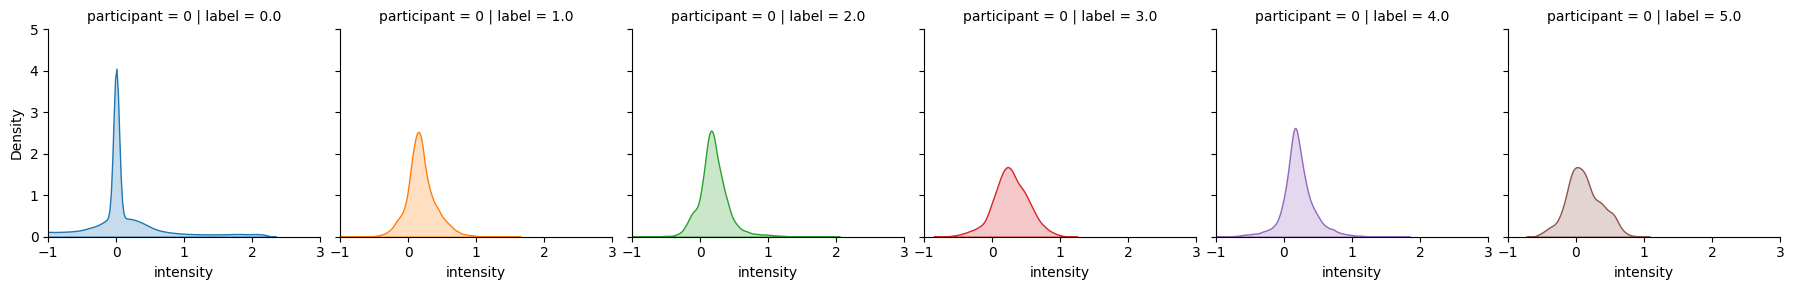

In [26]:
dataDir = './4Inference/EATT/T1w/'
modelsDir = './models/'
condition = '1000e_unregistered_crop'
norm_model = Normalizer()
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'normalization_model_' + condition + '.pt')))

train_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS, 'sub-057_ses-01_acq')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataFrame_orig, dataFrame_norm = generate_dist_dict(train_loader)
distributions_plot(dataFrame_orig[dataFrame_orig['participant']==str(0)])

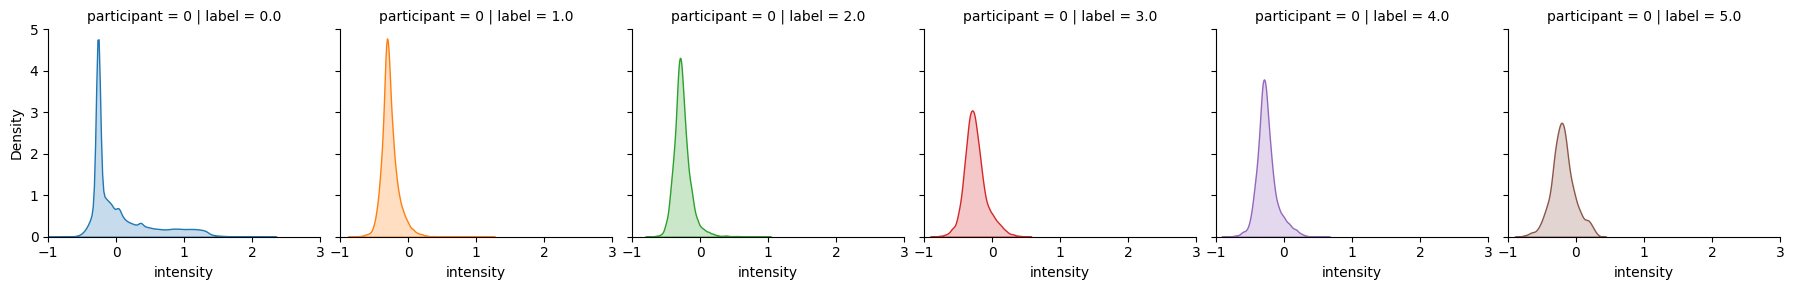

In [27]:
distributions_plot(dataFrame_norm[dataFrame_norm['participant']==str(0)])

## EATT - T2w

### After TTA

In [28]:
dataDir = './4Inference/EATT/T2w/'
modelsDir = './models/tta/EATT_T2w/'
condition = '1000e_unregistered_crop'
norm_model = Normalizer()
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'sub-010_ses-01_acq-T2SPCDAFLSAG_T2w_reg_to_BeLong_template_Warped_correct_spacing_tta_400e_normalization_model_' + condition + '.pt')))

train_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS, 'sub-010_ses-01_acq')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
dataFrame_orig, dataFrame_norm = generate_dist_dict(train_loader)

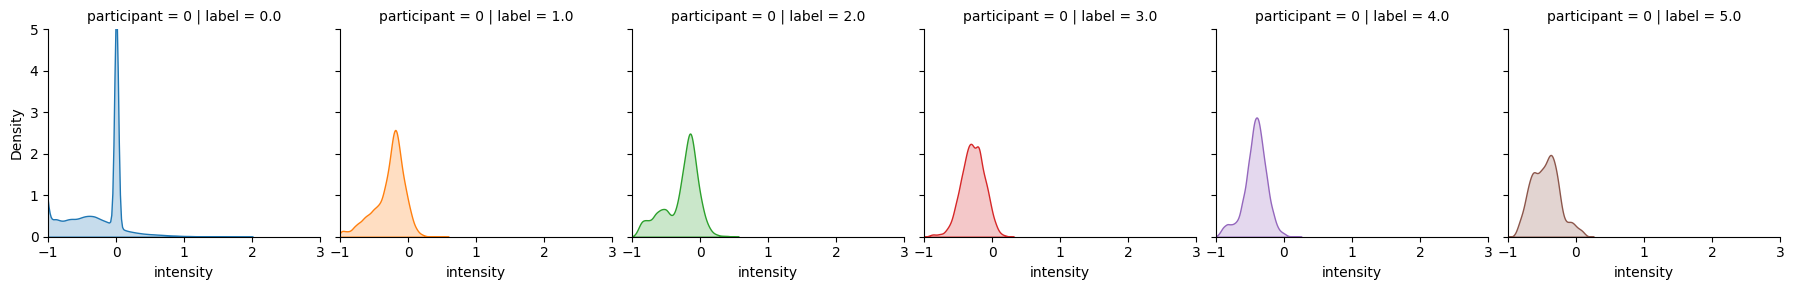

In [30]:
distributions_plot(dataFrame_orig[dataFrame_orig['participant']==str(0)])

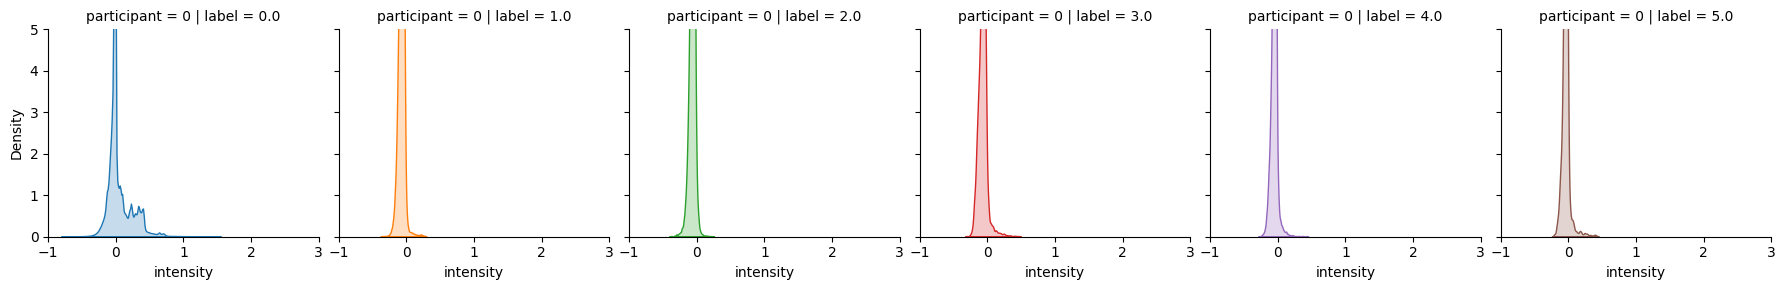

In [31]:
distributions_plot(dataFrame_norm[dataFrame_norm['participant']==str(0)])

### Before TTA

In [33]:
dataDir = './4Inference/EATT/T2w/'
modelsDir = './models/'
condition = '1000e_unregistered_crop'
norm_model = Normalizer()
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'normalization_model_' + condition + '.pt')))

train_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS, 'sub-010_ses-01_acq')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

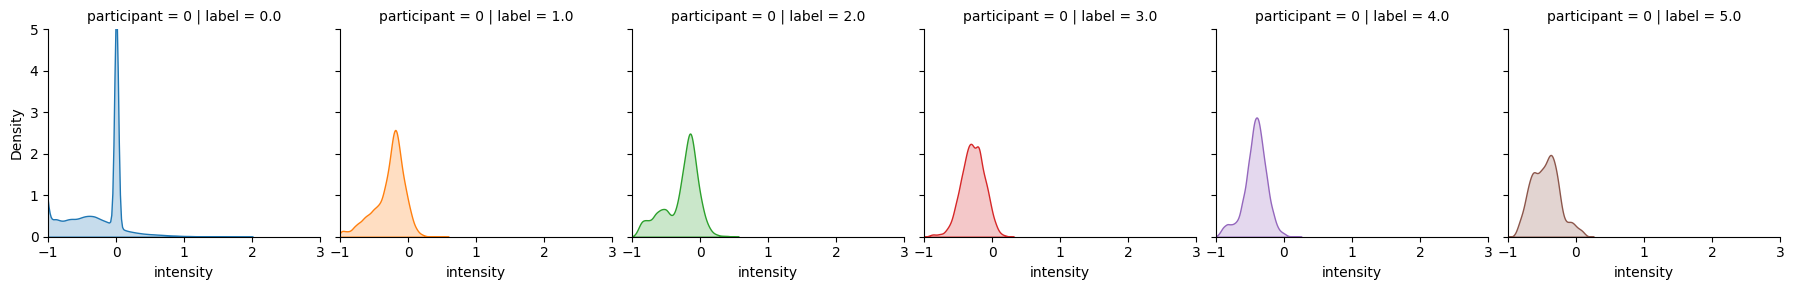

In [34]:
dataFrame_orig, dataFrame_norm = generate_dist_dict(train_loader)
distributions_plot(dataFrame_orig[dataFrame_norm['participant']==str(0)])

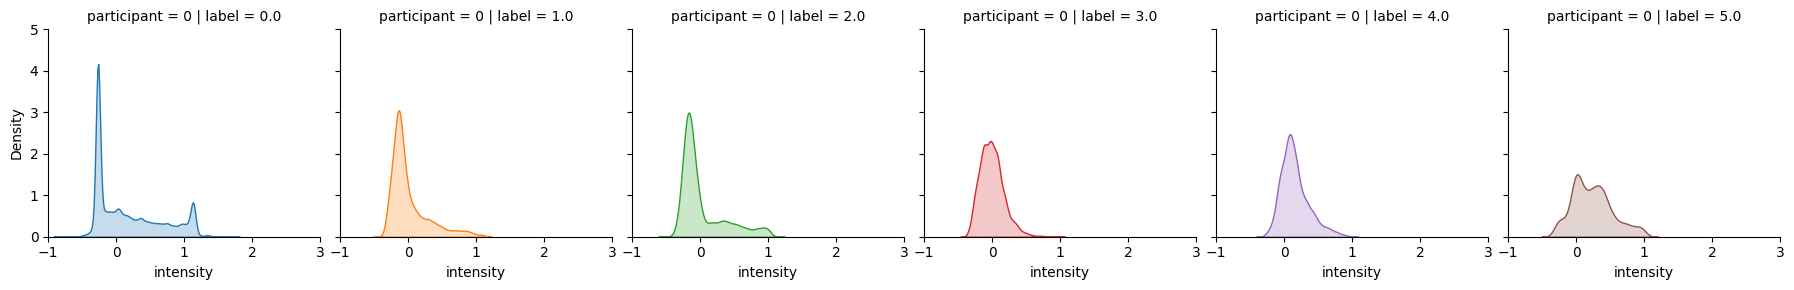

In [35]:
distributions_plot(dataFrame_norm[dataFrame_orig['participant']==str(0)])

## BeLong T1w

### After TTA

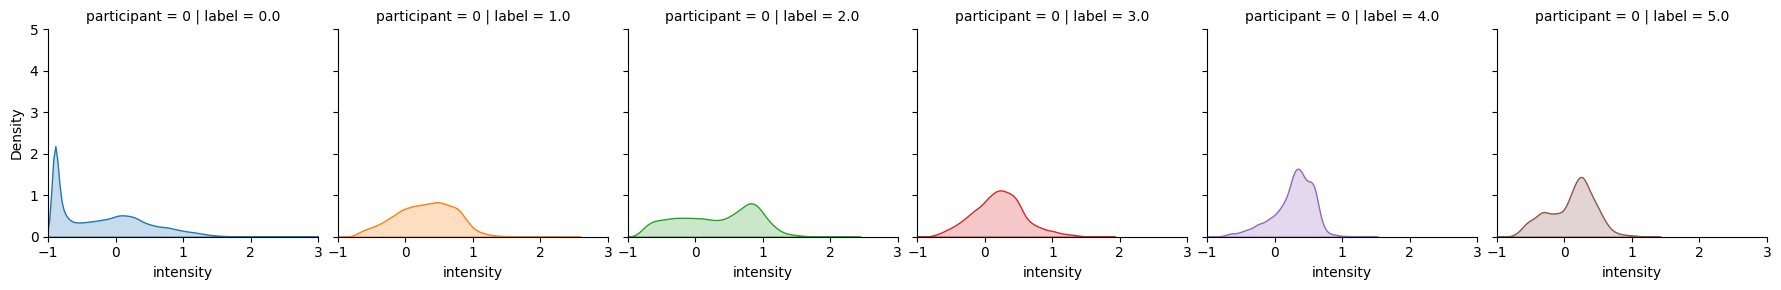

In [44]:
dataDir = './4Inference/BeLong/T1w/'
modelsDir = './models/tta/BeLong_T1w/'
condition = '1000e_unregistered_crop'
norm_model = Normalizer()
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'sub-023_ses-01_run-1_T1w_reg_to_BeLong_template_Warped_correct_spacing_tta_400e_normalization_model_' + condition + '.pt')))

train_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS, 'sub-023_ses-01_run-1')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataFrame_orig, dataFrame_norm = generate_dist_dict(train_loader)
distributions_plot(dataFrame_orig[dataFrame_norm['participant']==str(0)])

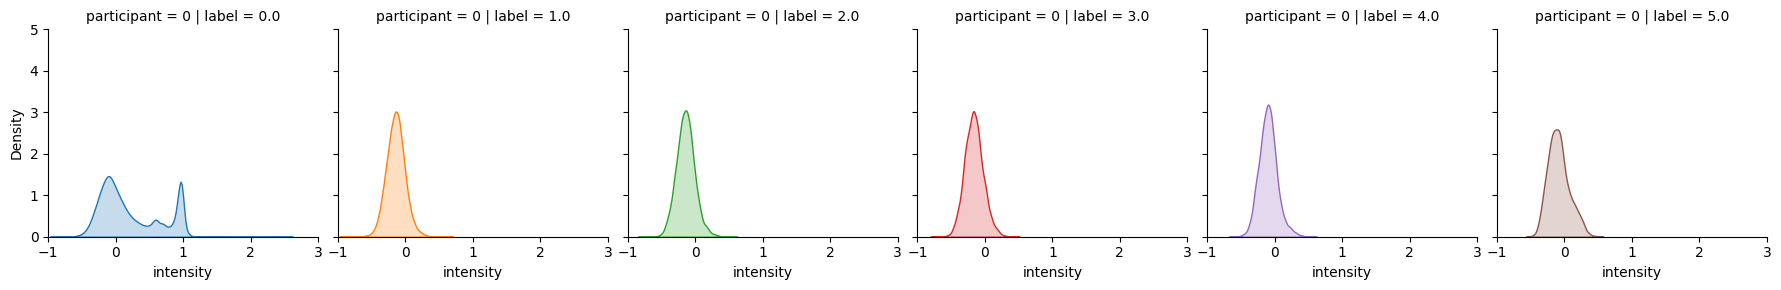

In [38]:
distributions_plot(dataFrame_norm[dataFrame_orig['participant']==str(0)])

### Before TTA

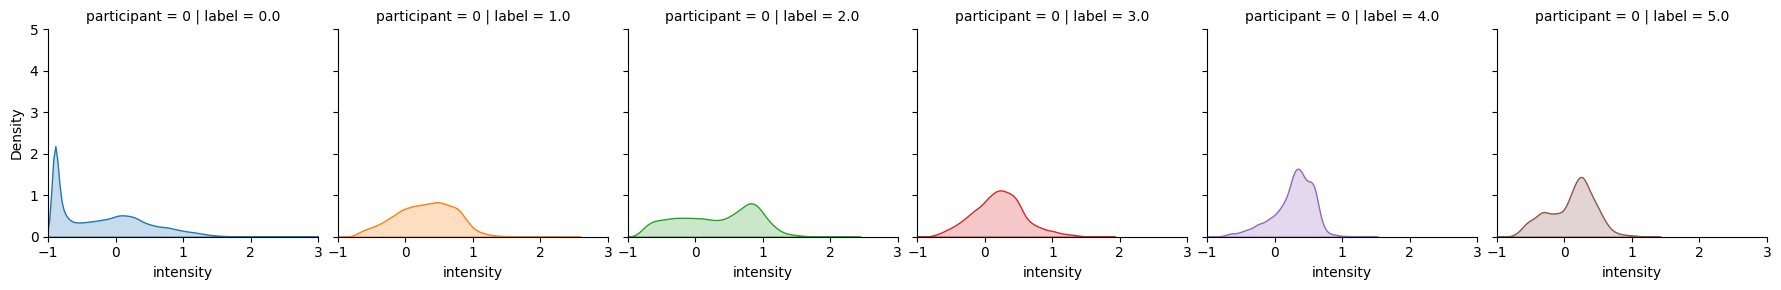

In [48]:
dataDir = './4Inference/BeLong/T1w/'
modelsDir = './models/'
condition = '1000e_unregistered_crop'
norm_model = Normalizer()
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'normalization_model_' + condition + '.pt')))

train_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS, 'sub-023_ses-01_run-1')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataFrame_orig, dataFrame_norm = generate_dist_dict(train_loader)
distributions_plot(dataFrame_orig[dataFrame_norm['participant']==str(0)])

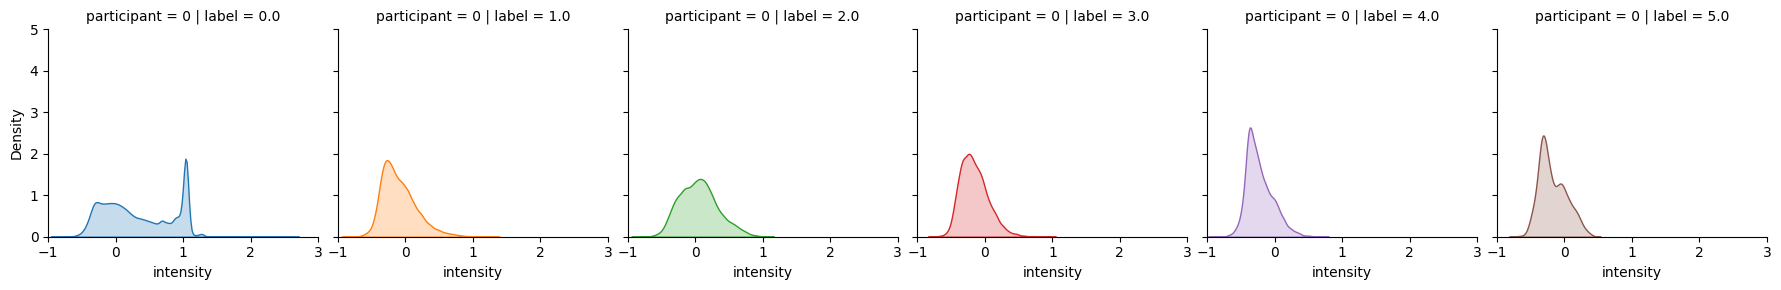

In [49]:
distributions_plot(dataFrame_norm[dataFrame_orig['participant']==str(0)])

# tmp

In [12]:
def dataloader(path, SPATIAL_SIZE, LABELS):
    # Data directory
    dataDir_img = path + 'images/'
    dataDir_seg = path + 'labels/'

    images = sorted(glob(os.path.join(dataDir_img, '*.nii.gz')))
    segs = sorted(glob(os.path.join(dataDir_seg, '*.nii.gz')))

    # Data prep
    train_files = [
        {'image': img, "label": seg} for img, seg in zip(images[:], segs[:])
    ]
    
    # Dataloader
    train_ds = Dataset(
        data=train_files, transform=get_val_transforms(SPATIAL_SIZE, LABELS))
    train_ds_loader = DataLoader(train_ds, batch_size=1, shuffle=False)


    return train_ds_loader

In [13]:
dataDir = './4Inference/Sydney/T1w/'
modelsDir = './models/'
condition = '1000e_unregistered_crop'
norm_model = Normalizer()
segmenter = DynUNet(
        spatial_dims=3,
        in_channels=CHANNELS,
        out_channels=len(LABELS),
        kernel_size=[3, 3, 3, 3, 3, 3],
        strides=[1, 2, 2, 2, 2, [2, 2, 1]],
        upsample_kernel_size=[2, 2, 2, 2, [2, 2, 1]],
        norm_name="instance",
        deep_supervision=False,
        res_block=True,
        dropout=.2,
    )
norm_model.load_state_dict(torch.load(
            os.path.join(modelsDir + 'normalization_model_' + condition + '.pt')))
segmenter.load_state_dict(torch.load(
            os.path.join(modelsDir + 'segmenter_model_' + condition + '.pt')))
norm_model.to(device)
segmenter.to(device)
train_loader = dataloader(dataDir, SPATIAL_SIZE, LABELS)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
import torch.nn as nn
import torch.nn.functional as F
class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x):
        entropy = F.softmax(x, dim=0) * F.log_softmax(x, dim=0)
        entropy = - entropy.sum()
        return entropy
        
criterion = HLoss()
# x = Variable(torch.randn(10, 10))
# w = Variable(torch.randn(10, 3), requires_grad=True)
# output = torch.matmul(x, w)
# loss = criterion(output)
# loss.backward()
# print(w.grad)

In [5]:
with torch.no_grad():
    for batch_idx, data in enumerate(train_loader):
        norm_model.to(device)

        input = (data["image"]).to(device)
        input = norm_model(input)
        
        data['pred'] = segmenter(input)[0]
        print(data['pred'].shape)
        print(criterion(data['pred']))

torch.Size([6, 64, 128, 128])
tensor(227694.1875, device='cuda:0')


# tmp

In [1]:
import logging
import shutil
import sys
import tempfile
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import nibabel as nib
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp


from monai.apps.deepedit.transforms import (AddGuidanceSignalDeepEditd,
                                            AddGuidanceFromPointsDeepEditd,
                                            AddInitialSeedPointMissingLabelsd,
                                            ResizeGuidanceMultipleLabelDeepEditd,
                                            AddRandomGuidanceDeepEditd,
                                            FindAllValidSlicesMissingLabelsd,
                                            FindDiscrepancyRegionsDeepEditd,
                                            SplitPredsLabeld,NormalizeLabelsInDatasetd)
from glob import glob
from monai.transforms import MapTransform, Resize
from typing import Dict, Hashable, Mapping, Optional, Sequence, Union
from monai.utils import InterpolateMode, ensure_tuple_rep
from monai.config import KeysCollection, print_config
from monai.data import Dataset, DataLoader, list_data_collate, decollate_batch, MetaTensor
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Orientationd,
    Resized,
    ScaleIntensityRanged,
    RandRotate90d,
    ScaleIntensityd,
    SqueezeDimd,
    ToNumpyd,
    Compose,
    AddChanneld,
    RandCropByPosNegLabeld,
    AsDiscrete,
    RandFlipd,
    RandShiftIntensityd,
    NormalizeIntensityd,
    SelectItemsd,
    ToTensord,
    SpatialPadd,
    RandCropByPosNegLabeld,
    RandZoomd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandScaleIntensityd,
)


from monai.utils import first
from monai.networks.nets import DynUNet
from monai.networks.utils import one_hot

In [2]:
# Data directory
dataDir_img = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/images/' 
dataDir_seg = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/labels/' 

images = sorted(glob(os.path.join(dataDir_img, '*.nii.gz')))
segs = sorted(glob(os.path.join(dataDir_seg, '*.nii.gz')))


In [3]:
train_files = [
    {'image': img, "label": seg} for img, seg in zip(images[:12],segs[:12])
]
val_files = [
    {'image': img, "label": seg} for img, seg in zip(images[12:],segs[12:])
]

In [4]:
val_files

[{'image': '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/images/sub-026_ses-01_acq-T2wCSpine_run-1_T2w.nii.gz',
  'label': '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/labels/sub-026_ses01_acqT2wCSpine_run1_T2w_labels.nii.gz'},
 {'image': '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/images/sub-027_ses-01_acq-T2wCSpine_run-1_T2w.nii.gz',
  'label': '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/labels/sub-027_ses01_acqT2wCSpine_run1_T2w_labels.nii.gz'},
 {'image': '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/images/sub-029_ses-01_acq-T2wCSpine_run-1_T2w.nii.gz',
  'label': '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset/labels/sub-029_ses01_acqT2wCSpine_run1_T2w_labels.nii.gz'}]

In [5]:
labels = {
            "vertical": 1,
            "superior longitudinal": 2,
            "inferior longitudinal": 3,
            "genioglossus": 4,
            "hyoglossus": 5,
            "background": 0,
        }

spatial_size = [64,128,128]
number_intensity_ch = 1

In [5]:
train_transforms = Compose([LoadImaged(keys=("image", "label"), ),
            NormalizeLabelsInDatasetd(keys="label", label_names=labels), # check
            EnsureChannelFirstd(keys=("image", "label")),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
                            
            # image size
            Resized(keys=("image", "label"), spatial_size=spatial_size, mode=("area", "nearest")),
            
            # data augmentation
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=spatial_size,
                pos=1.,
                neg=1.,
                num_samples=4,
                image_key="image",
                image_threshold=0,
                ),
            RandZoomd(
                keys=["image", "label"],
                min_zoom=0.9,
                max_zoom=1.2,
                mode=("trilinear", "nearest"),
                align_corners=(True, None),
                prob=0.15,
                ),
            RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
            RandGaussianSmoothd(
                keys=["image"],
                sigma_x=(0.5, 1.15),
                sigma_y=(0.5, 1.15),
                sigma_z=(0.5, 1.15),
                prob=0.15,
                ),
            RandScaleIntensityd(keys=["image"], factors=0.3, prob=0.15),
            RandFlipd(["image", "label"], spatial_axis=[0], prob=0.5),
            RandFlipd(["image", "label"], spatial_axis=[1], prob=0.5),
            RandFlipd(["image", "label"], spatial_axis=[2], prob=0.5),
                            
            # Transforms for click simulation
            FindAllValidSlicesMissingLabelsd(keys="label", sids="sids"),
            ToTensord(keys=("image", "label")),
            SelectItemsd(keys=("image", "label",  "label_names"))
                           ])


val_transforms = Compose([LoadImaged(keys=("image", "label"), ),
            NormalizeLabelsInDatasetd(keys="label", label_names=labels),
            EnsureChannelFirstd(keys=("image", "label")),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),                            
            Resized(keys=("image", "label"), spatial_size=spatial_size, mode=("area", "nearest")),
            FindAllValidSlicesMissingLabelsd(keys="label", sids="sids"),
            ToTensord(keys=("image", "label")),]                    
                        )

post_transforms = [
        Activationsd(keys="pred", softmax=True),
        AsDiscreted(keys=("pred","label"), argmax=(True,False),to_onehot=len(labels))]


In [6]:
from monai.transforms import RandSpatialCropSamplesd, Invertd, Affined, SpatialCropd

In [7]:

pre_transforms = Compose([
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys="image", axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        SpatialCropd(keys="image", roi_center=(
            50, 295, 210), roi_size=spatial_size), # Training data - roi_center=(30, 250, 210)
#         Affined(keys="image", 
#                 rotate_params=(np.pi/4,np.pi/4,np.pi/4), 
#                 scale_params=(1.2,1.2,1.2), 
#                 spatial_size=spatial_size),
        EnsureTyped(keys="image")
    ])

post_transforms = [
        EnsureTyped(keys="pred"),
        Activationsd(keys="pred", softmax=True),
        AsDiscreted(keys="pred", argmax=True),
        Invertd(keys="pred", transform=pre_transforms, orig_keys="image"),
    ]

In [8]:
from utils.transforms import get_infer_transforms, get_post_transforms

In [9]:
pre_transform = get_infer_transforms(spatial_size)
post_transforms = get_post_transforms(pre_transform)

In [10]:
# train_ds = Dataset(data=train_files, transform=train_transforms)
# train_ds_loader = DataLoader(train_ds, batch_size=1,shuffle=True,
#                       num_workers=4,collate_fn=list_data_collate,
#                       pin_memory=torch.cuda.is_available())

val_ds = Dataset(data=val_files, transform=pre_transform)
val_ds_loader = DataLoader(val_ds, batch_size=1,shuffle=False,
                      num_workers=4,collate_fn=list_data_collate,)

In [11]:
len(val_ds_loader)

3

In [12]:
for batch_idx, data in enumerate(val_ds_loader):

    input_img= data['image']
    for i in range(len(input_img)):
        print(i)
#         plt.imshow(input_img[i])[0][20]
# #     data['pred'] = model(input_img)[0]
    data['pred'] = data['image'][0]

    for t in post_transforms:
        tname = type(t).__name__
        data = t(data)
    

0


RuntimeError: applying transform <bound method Cropd.inverse of <monai.transforms.croppad.dictionary.SpatialCropd object at 0x7f42093f8ed0>>

In [80]:
from monai.transforms import BatchInverseTransform

In [37]:
batch_inverter = BatchInverseTransform(pre_transforms, val_ds_loader)

In [38]:
len(batch_inverter)

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f75fd037a70>
Traceback (most recent call last):
  File "/scratch/qbi/uqfribe1/postdoc/miniconda3/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/scratch/qbi/uqfribe1/postdoc/miniconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


TypeError: object of type 'BatchInverseTransform' has no len()

In [ ]:
for ii,i in enumerate(val_ds_loader):
            original_affine = i["image_meta_dict"]["affine"][0].numpy()
            input = (i["image"]).to(device)
            input = norm_model(input)
            i['pred'] = segmenter(input)[0] 
            i['image'] = i['image'][0] 
#             print(segmenter(input).shape)

            for t in test_post_transforms:
                tname = type(t).__name__
                i = t(i)

            nib.save(
                    nib.Nifti1Image(i['pred'].astype(np.uint8), original_affine), os.path.join(save_root,'tta_'+ name))

## Activation function

In [3]:
# WRONG!
# import torch.nn as nn

# class activation(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.channels = channels
#         self.sigma = torch.randn(1, self.channels,1, 1, 1).requires_grad_(True).to("cuda")
#     def forward(self, x):
#         x = -x**2/self.sigma**2
#         x = torch.exp(x)
#         return x

In [7]:
import torch.nn as nn
from torch import Tensor
from torch.nn.parameter import Parameter

class activation(nn.Module):
    __constants__ = ['num_parameters']
    num_parameters: int

    def __init__(self, num_parameters: int = 1, init: float = 0.25,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.num_parameters = num_parameters
        super(activation, self).__init__()
        self.sigma = Parameter(torch.reshape(torch.empty(num_parameters, **factory_kwargs).fill_(init), (1,num_parameters,1,1,1)))

    def forward(self, input: Tensor) -> Tensor:
        x = -input**2/self.sigma**2
        x = torch.exp(x)
        return x

    def extra_repr(self) -> str:
        return 'num_parameters={}'.format(self.num_parameters)

In [8]:
# import torch
# import matplotlib.pyplot as plt
# from scipy.ndimage import center_of_mass 
# import nibabel as nib

# x = data['image'][0][0]
# print(x.to('cuda'))

# with torch.no_grad():
#     act = activation(3)
#     bla = act.forward(x.to("cuda"))
#     print(bla.shape)


# fig = plt.figure(figsize=(30,5))
# ax1 = fig.add_subplot(1,1,1)
# ax1.imshow(np.rot90(train_ds_loader[0][0][20,:,:]), cmap='gray')

# ax2 = fig.add_subplot(1,2,1)
# ax2.imshow(np.rot90(output[0][0][20,:,:]), cmap='gray')
# plt.tight_layout()

## Plots

In [19]:
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass 
import nibabel as nib

def figures(epoch,normalized_input,input,folder):
    
    save_root = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/'+ str(folder) + '/'

    if not osp.exists(save_root):
        os.makedirs(save_root)
        
    fig = plt.figure(figsize=(30,5))
    ax1 = fig.add_subplot(1,1,1)
    norm_input = normalized_input[0][0][20,:,:]
    ax1.imshow(np.rot90(norm_input), cmap='gray', vmax = np.max(norm_input),  vmin = np.min(norm_input))

    ax2 = fig.add_subplot(1,2,1)
    input = input[0][0][20,:,:]
    ax2.imshow(np.rot90(input), cmap='gray', vmax = np.max(input),  vmin = np.min(input))
    plt.tight_layout()
    plt.savefig(save_root + 'TTA_check_epoch' + str(epoch),dpi=300)

## Segmenter only

1
1
1
Loss: 3.0127172668774924. Dice score in the validation set: 0.04492533206939697


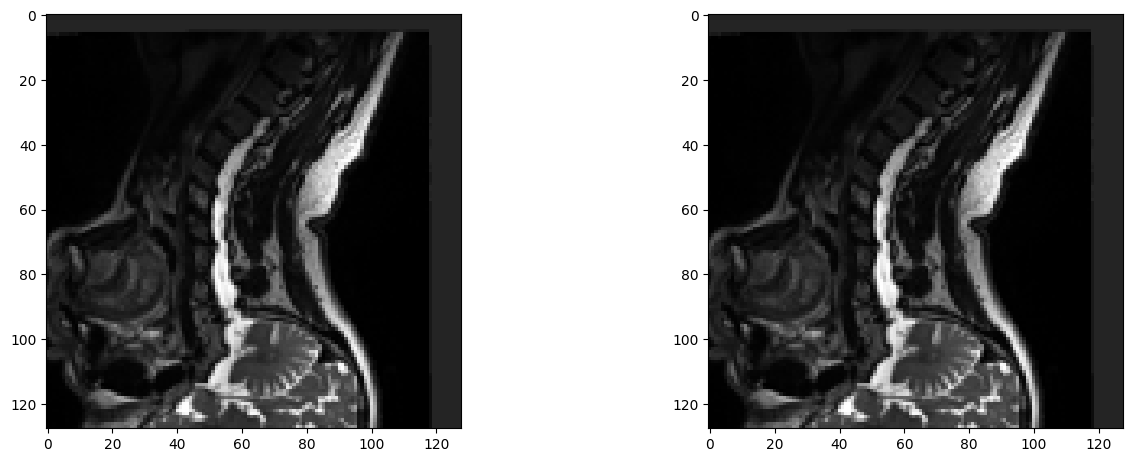

In [34]:
segmenter = DynUNet(
    spatial_dims=3,
    in_channels= 1, 
    out_channels=len(labels),
    kernel_size=[3, 3, 3, 3, 3, 3],
    strides=[1, 2, 2, 2, 2, [2, 2, 1]],
    upsample_kernel_size=[2, 2, 2, 2, [2, 2, 1]],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
    dropout = .2,
)
# segmenter.load_state_dict(torch.load(
#     os.path.join("./models/segmenter_model_only_1channel_600e.pt")))

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer =torch.optim.Adam(segmenter.parameters(),0.0001)
dice_metric = DiceMetric(include_background=True,reduction="mean")
device = torch.device("cuda")

       
def train(model, dataloader, optimizer, loss_func):
    model.train()
    total_loss=0
    for batch_idx, data in enumerate(dataloader):
        model.to(device)
        input_img, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(input_img)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss.detach()
    return total_loss/len(dataloader), input_img.detach().to('cpu').numpy()


def test(model, dataloader, metric):
    model.eval()
    
    mean_score = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            model.to(device)

            input_img= data['image'].to(device)

            data['pred'] = model(input_img)[0]
            data['label'] = data['label'][0]
            
            for t in post_transforms:
                tname = type(t).__name__
                data = t(data)
            target = data['label'].to(device)
            metric(data['pred'], target)

        score = metric.aggregate(reduction = 'mean').item()
        metric.reset()
    return score

for epoch in range(1,2):
    loss, input_img = train(segmenter, train_ds_loader, optimizer, loss_function)
    dice_score = test(segmenter, val_ds_loader, dice_metric)
    if epoch%10 == 0 or epoch==1:
        figures(epoch,input_img,input_img,'segmenter_training')
    print('Loss: %s. Dice score in the validation set: %s' % (str(loss),str(dice_score)))

torch.save(segmenter.state_dict(),'./models/segmenter_model_only_1channel_800e.pt')

## TTA: Normalizer + Segmenter

In [8]:
class Normalizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1,16,3,padding=1)
        self.conv2 = nn.Conv3d(16,16,3,padding=1)
        self.conv3 = nn.Conv3d(16,1,3,padding=1)
        self.act1 = activation(16)
        self.act2 = activation(16)
       
    def forward(self, input):
        x = self.conv1(input)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)

        return x
    
norm_model = Normalizer()
segmenter = DynUNet(
    spatial_dims=3,
    in_channels= 1, 
    out_channels= len(labels),
    kernel_size=[3, 3, 3, 3, 3, 3],
    strides=[1, 2, 2, 2, 2, [2, 2, 1]],
    upsample_kernel_size=[2, 2, 2, 2, [2, 2, 1]],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
    dropout = .2,
)

In [10]:
print(list(norm_model.named_parameters()))

[('conv1.weight', Parameter containing:
tensor([[[[[-8.2955e-02,  3.9791e-02,  4.1447e-02],
           [-1.6644e-01,  2.7933e-02, -5.6035e-02],
           [-1.5715e-02, -4.1788e-02,  5.2360e-02]],

          [[ 1.3689e-01,  9.9860e-02, -9.8354e-02],
           [-4.1001e-02,  1.8475e-02,  1.2416e-02],
           [ 1.4580e-01, -1.6260e-01, -4.9526e-02]],

          [[ 8.9575e-02, -2.9461e-02,  5.9405e-02],
           [ 1.7418e-01,  1.1312e-01, -1.1750e-01],
           [-1.7997e-01, -1.1408e-01, -1.2810e-01]]]],



        [[[[-6.1043e-02,  1.1239e-01, -2.7491e-02],
           [ 1.3749e-01, -1.7577e-01, -4.0486e-02],
           [-1.1336e-01,  9.8282e-02, -1.9242e-01]],

          [[ 2.6738e-02,  1.8995e-01,  7.0159e-02],
           [-4.3776e-02, -8.6958e-02, -7.8138e-03],
           [ 3.6659e-02,  1.3009e-01, -7.0442e-02]],

          [[ 2.3347e-02,  1.0595e-01,  2.4967e-02],
           [ 1.7368e-01, -1.5607e-01, -8.2049e-02],
           [ 1.3066e-01, -1.7940e-01, -1.1105e-01]]]],



    

In [13]:
params = list(norm_model.parameters()) + list(segmenter.parameters())
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer =torch.optim.Adam(params,0.0001)
dice_metric = DiceMetric(include_background=True,reduction="mean")
device = torch.device("cuda")

# segmenter.load_state_dict(torch.load(
#     os.path.join('./models/segmenter_model.pt')))
# norm_model.load_state_dict(torch.load(
#     os.path.join('./models/normalization_model.pt')))

       
def train(model1, model2, dataloader, optimizer, loss_func):
    model1.train()
    model2.train()
    total_loss=0
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        
        model1.to(device)
        model2.to(device)
        
        input_img, target = data['image'].to(device), data['label'].to(device)
        
        norm_input = model1(input_img)
        output = model2(norm_input)
        
        loss = loss_func(output, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loss.detach()
    return total_loss/len(dataloader), norm_input.detach().to('cpu').numpy(), input_img.detach().to('cpu').numpy()


def test(model1, model2, dataloader, metric):
    model1.eval()
    model2.eval()
    
    mean_score = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            model1.to(device)
            model2.to(device)

            input_img= data['image'].to(device)

            norm_input = model1(input_img)
            data['pred'] = model2(norm_input)[0]
            data['label'] = data['label'][0]
            
            for t in post_transforms:
                tname = type(t).__name__
                data = t(data)
            target = data['label'].to(device)
            metric(data['pred'], target)

            
        score = metric.aggregate(reduction = 'mean').item()
        metric.reset()
    return score



for epoch in range(1,2):
    loss, norm_input, input_img = train(norm_model, segmenter, train_ds_loader, 
                                     optimizer, loss_function)
    dice_score = test(norm_model, segmenter, val_ds_loader, dice_metric)
#     if epoch%10 == 0 or epoch==1:
#         figures(epoch,norm_input,input_img, 'tta_training')
    print('Loss: %s. Dice score in the validation set: %s' % (str(loss),str(dice_score)))
    
# torch.save(norm_model.state_dict(),'./models/normalization_model_2e.pt')
# torch.save(segmenter.state_dict(),'./models/segmenter_model_2e.pt')


Loss: 2.608349541823069. Dice score in the validation set: 0.11569162458181381


In [14]:
print(list(norm_model.named_parameters()))

[('conv1.weight', Parameter containing:
tensor([[[[[-0.0836,  0.0391,  0.0407],
           [-0.1664,  0.0280, -0.0559],
           [-0.0159, -0.0420,  0.0523]],

          [[ 0.1362,  0.0991, -0.0992],
           [-0.0410,  0.0184,  0.0124],
           [ 0.1455, -0.1629, -0.0498]],

          [[ 0.0889, -0.0301,  0.0586],
           [ 0.1742,  0.1131, -0.1175],
           [-0.1801, -0.1143, -0.1283]]]],



        [[[[-0.0595,  0.1140, -0.0259],
           [ 0.1390, -0.1742, -0.0388],
           [-0.1120,  0.0997, -0.1909]],

          [[ 0.0283,  0.1915,  0.0717],
           [-0.0423, -0.0854, -0.0062],
           [ 0.0380,  0.1314, -0.0690]],

          [[ 0.0249,  0.1075,  0.0265],
           [ 0.1751, -0.1546, -0.0805],
           [ 0.1320, -0.1781, -0.1097]]]],



        [[[[ 0.1707, -0.0056, -0.0621],
           [-0.0055, -0.1182, -0.1514],
           [-0.1924,  0.1249, -0.0099]],

          [[-0.0097,  0.0278,  0.0217],
           [-0.0970, -0.0509,  0.1377],
           [ 0.079

## TTA - val dataset

(6, 64, 128, 128)
(6, 64, 128, 128)
Loss: 0.8015086054801941. Dice score in the validation set: 0.39219892024993896
(6, 64, 128, 128)
(6, 64, 128, 128)
Loss: 0.7673918604850769. Dice score in the validation set: 0.40751704573631287


KeyboardInterrupt: 

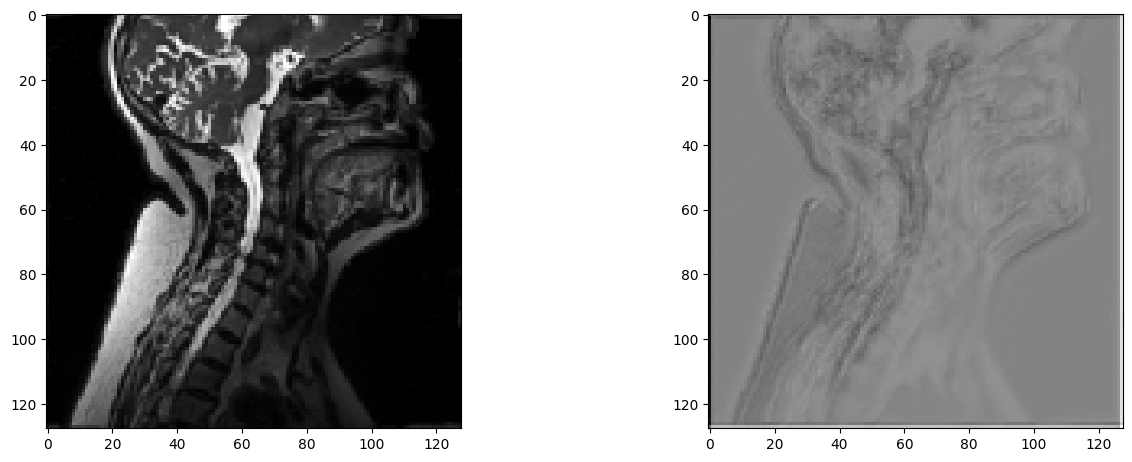

In [109]:
post_transforms = [
        Activationsd(keys="pred", softmax=True),
        AsDiscreted(keys=("pred","label"), argmax=(True,False),to_onehot=len(labels))]


for i in range(len(val_files)):
    name = os.path.split(val_files[i]['image'])[1]
    val_ds = Dataset(data=[val_files[i]], transform=val_transforms)
    val_ds_loader = DataLoader(val_ds, batch_size=1,shuffle=False,
                          num_workers=4,collate_fn=list_data_collate,)

    params = list(norm_model.parameters())
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
    optimizer =torch.optim.Adam(params,0.0001)
    dice_metric = DiceMetric(include_background=True,reduction="mean")
    device = torch.device("cuda")

    segmenter.load_state_dict(torch.load(
        os.path.join('./models/segmenter_model.pt')))
    norm_model.load_state_dict(torch.load(
        os.path.join('./models/normalization_model.pt')))


    def train(model1, model2, dataloader, optimizer, loss_func):
        model1.train()
        model2.eval()
        total_loss=0
        for batch_idx, data in enumerate(dataloader):
            optimizer.zero_grad()

            model1.to(device)
            model2.to(device)

            input_img, target = data['image'].to(device), data['label'].to(device)

            norm_input = model1(input_img)
            output = model2(norm_input)

            loss = loss_func(output, target)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loss.detach()
        return total_loss/len(dataloader), norm_input.detach().to('cpu').numpy(), input_img.detach().to('cpu').numpy()


    def test(model1, model2, dataloader, metric):
        model1.eval()
        model2.eval()

        mean_score = 0
        with torch.no_grad():
            for batch_idx, data in enumerate(dataloader):
                model1.to(device)
                model2.to(device)

                input_img= data['image'].to(device)

                norm_input = model1(input_img)
                data['pred'] = model2(norm_input)[0]
                data['label'] = data['label'][0]


                for t in post_transforms:
                    tname = type(t).__name__
                    data = t(data)
                target = data['label'].to(device)
                metric(data['pred'], target)
                

            score = metric.aggregate(reduction = 'mean').item()
            metric.reset()
        return score


    for epoch in range(1,100):
        loss, norm_input, input_img = train(norm_model, segmenter, val_ds_loader, optimizer, loss_function)
        dice_score = test(norm_model, segmenter, val_ds_loader, dice_metric)
        if epoch%10 == 0 or epoch==1:
            figures(epoch,norm_input,input_img, 'tta_test')
        print('Loss: %s. Dice score in the validation set: %s' % (str(loss),str(dice_score)))
    
    print(list(segmenter.parameters())[0][0][0][0])
    print(list(norm_model.parameters())[0][0][0][0])
    
    torch.save(norm_model.state_dict(),'./models/'+ name + 'normalization_model_tta_ValSet.pt')


In [102]:
# segmenter.load_state_dict(torch.load(
#         os.path.join('./models/segmenter_model.pt')))

# norm_model.load_state_dict(torch.load(
#         os.path.join('./models/normalization_model.pt')))
# print(list(segmenter.parameters())[0][0][0][0])
# print(list(norm_model.parameters())[0][0][0][0])

tensor([[ 5.7129e-04,  6.6126e-01,  6.3162e-02],
        [ 2.1697e-01,  1.8337e-01, -1.6191e-01],
        [-8.1509e-02, -1.1002e-01, -1.5137e-01]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[ 0.1565,  0.0465,  0.1338],
        [-0.0375,  0.0485, -0.1032],
        [ 0.0929, -0.0126, -0.1837]], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [21]:
import nibabel as nib
import numpy as np
import os
import os.path as osp
from monai.inferers import SimpleInferer

pre_transforms = Compose([
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys="image", axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        Resized(keys="image", spatial_size=spatial_size, mode="area"),
        EnsureTyped(keys="image")
    ])

for i in range(len(val_files)):
    name = os.path.split(val_files[i]['image'])[1]
    print(name)
    val_ds = Dataset(data=[val_files[i]], transform=pre_transforms)
    val_ds_loader = DataLoader(val_ds, batch_size=1,shuffle=False,
                          num_workers=4,collate_fn=list_data_collate,)

    device = torch.device("cuda")

    root_dir = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/models/'
    norm_model.load_state_dict(torch.load(
        os.path.join(root_dir,  name + "normalization_model_tta_200e_ValSet.pt")))
    segmenter.load_state_dict(torch.load(
        os.path.join(root_dir, "segmenter_model_800e_Reg.pt")))
    # segmenter.load_state_dict(torch.load(
    #     os.path.join(root_dir, "segmenter_model_only_1channel.pt")))

    norm_model.to(device)
    segmenter.to(device)
    norm_model.eval()
    segmenter.eval()


    save_root = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/predictions'

    if not osp.exists(save_root):
        os.makedirs(save_root)

    def linear_transform(input, scale):
        return input * scale 

    with torch.no_grad():
        for ii,i in enumerate(val_ds_loader):
            original_affine = i["image_meta_dict"]["affine"][0].numpy()
            input = (i["image"]).to(device)
            input = norm_model(input)
            i['pred'] = segmenter(input)[0] 
            i['image'] = i['image'][0] 
#             print(segmenter(input).shape)

            for t in test_post_transforms:
                tname = type(t).__name__
                i = t(i)

            nib.save(
                    nib.Nifti1Image(i['pred'].astype(np.uint8), original_affine), os.path.join(save_root,'tta_'+ name))

sub-026_ses-01_acq-T2wCSpine_run-1_T2w_BeLong_image_rigid_registered_to_template_Warped.nii.gz
sub-027_ses-01_acq-T2wCSpine_run-1_T2w_BeLong_image_rigid_registered_to_template_Warped.nii.gz
sub-029_ses-01_acq-T2wCSpine_run-1_T2w_BeLong_image_rigid_registered_to_template_Warped.nii.gz


## Normalizer + pre-trained segmenter

In [1]:
class Normalizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1,16,3,padding=1)
        self.conv2 = nn.Conv3d(16,16,3,padding=1)
        self.conv3 = nn.Conv3d(16,1,3,padding=1)
        self.act1 = activation(16)
        self.act2 = activation(16)
       
    def forward(self, input):
        x = self.conv1(input)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.conv3(x)

        return x

norm_model = Normalizer()
segmenter = DynUNet(
    spatial_dims=3,
    in_channels= 1, 
    out_channels=len(labels),
    kernel_size=[3, 3, 3, 3, 3, 3],
    strides=[1, 2, 2, 2, 2, [2, 2, 1]],
    upsample_kernel_size=[2, 2, 2, 2, [2, 2, 1]],
    norm_name="instance",
    deep_supervision=False,
    res_block=True,
    dropout = .2,
)
segmenter.load_state_dict(torch.load(
    os.path.join('./models/segmenter_model_only_1channel.pt')))

device = torch.device("cuda")
params = list(norm_model.parameters())
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer =torch.optim.Adam(params,.0001)
dice_metric = DiceMetric(include_background=True,reduction="mean")

       
def train(model1, model2, dataloader, optimizer, loss_func):
    model1.train()
    model2.eval()
    total_loss=0
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        
        model1.to(device)
        model2.to(device)
        input_img, target = data['image'].to(device), data['label'].to(device)
        norm_input = model1(input_img)
        output = model2(norm_input)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loss.detach()
    return total_loss/len(dataloader)




for epoch in range(1,9):
    loss = train(norm_model, segmenter, train_ds_loader, optimizer, loss_function)
    dice_score = test(norm_model, segmenter, val_ds_loader, dice_metric)
    if epoch%10 == 0 or epoch==1:
        figures(epoch,norm_input,input_img)
    print('Loss: %s. Dice score in the validation set: %s' % (str(loss),str(dice_score)))


torch.save(norm_model.state_dict(),'./models/normalization_model_PTS.pt')

## Inference

In [5]:
class Restored(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        ref_image: str,
        has_channel: bool = True,
        mode: str = InterpolateMode.NEAREST,
        align_corners: Union[Sequence[Optional[bool]], Optional[bool]] = None,
        meta_key_postfix: str = "meta_dict",
    ):
        super().__init__(keys)
        self.ref_image = ref_image
        self.has_channel = has_channel
        self.mode = ensure_tuple_rep(mode, len(self.keys))
        self.align_corners = ensure_tuple_rep(align_corners, len(self.keys))
        self.meta_key_postfix = meta_key_postfix

    def __call__(self, data):
        d = dict(data)
        meta_dict = (
            d[self.ref_image].meta
            if d.get(self.ref_image) is not None and isinstance(d[self.ref_image], MetaTensor)
            else d.get(f"{self.ref_image}_{self.meta_key_postfix}", {})
        )

        for idx, key in enumerate(self.keys):
            result = d[key]
            current_size = result.shape[1:] if self.has_channel else result.shape
            spatial_shape = meta_dict.get("spatial_shape", current_size)
            spatial_size = spatial_shape[-len(current_size) :]
            # Undo Spacing
            if torch.any(np.not_equal(current_size, spatial_size)):
                
                resizer = Resize(spatial_size=spatial_size, mode=self.mode[idx])
                result = resizer(result, mode=self.mode[idx], align_corners=self.align_corners[idx])
            d[key] = result if len(result.shape) <= 3 else result[0] if result.shape[0] == 1 else result

            meta = d.get(f"{key}_{self.meta_key_postfix}")
            if meta is None:
                meta = dict()
                d[f"{key}_{self.meta_key_postfix}"] = meta
            meta["affine"] = meta_dict.get("original_affine")
        return d
    


In [6]:
from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Orientationd,
    Resized,
    ScaleIntensityRanged,
    SqueezeDimd,
    ToNumpyd,
    Compose,
    AddChanneld,
)

from monai.apps.deepedit.transforms import (
    AddGuidanceFromPointsDeepEditd,
    AddGuidanceSignalDeepEditd,
    DiscardAddGuidanced,
    ResizeGuidanceMultipleLabelDeepEditd,
)

pre_transforms = Compose([
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys="image", axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        Resized(keys="image", spatial_size=spatial_size, mode="area"),
        EnsureTyped(keys="image")
    ])


test_post_transforms =[
        EnsureTyped(keys="pred"),
        Orientationd(keys=('image',"pred"), axcodes="LAS"),
        Activationsd(keys="pred", softmax=True),
        AsDiscreted(keys=("pred"), argmax=True),
        SqueezeDimd(keys="pred", dim=0),
        ToNumpyd(keys="pred"),
        AddChanneld(keys='pred'),
        Restored(keys="pred", ref_image="image", mode="nearest"),
    ]

In [7]:
# Data directory
# dataDir_img = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/dataset2/EATT_rigidReg_biasFieldCorrection' 
dataDir_img = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/registered_dataset/images/' 

images = sorted(glob(os.path.join(dataDir_img, '*.nii.gz')))
# segs = sorted(glob(os.path.join(dataDir_seg, '*T2w_labels.nii.gz')))

new_files = [
    {'image': img} for img in images[:]]


In [8]:
from monai.data import Dataset, DataLoader, decollate_batch

images_ds = Dataset(data=new_files, transform=pre_transforms)
images_loader = DataLoader(images_ds, batch_size=1,shuffle=False)


(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
(1, 1, 64, 128, 128)
50 50 50
tensor(-0.0007)
Metadata
	sizeof_hdr: 348
	extents: 0
	session_error: 0
	dim_info: 0
	dim: tensor([  3,  64, 320, 320,   1,   1,   1,   1], dtype=torch.int16)
	intent_p1: 0.0
	intent_p2: 0.0
	intent_p3: 0.0
	intent_code: 0
	datatype: 64
	bitpix: 64
	slice_start: 0
	pixdim: tensor([1.0000, 0.8000, 0.8000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000])
	vox_offset: 0.0
	scl_slope: nan
	scl_inter: nan
	slice_end: 0
	slice_code: 0
	xyzt_units: 2
	cal_max: 0.0
	cal_min: 0.0
	slice_duration: 0.0
	toffset: 0.0
	glmax: 0
	glmin: 0
	qform_code: 1
	sform_code: 1
	quatern_b: 0.00013994531764183193
	quatern_c: -0.014699936844408512
	quatern_d: 0.009518678300082684
	qoffset_x: -17.77283

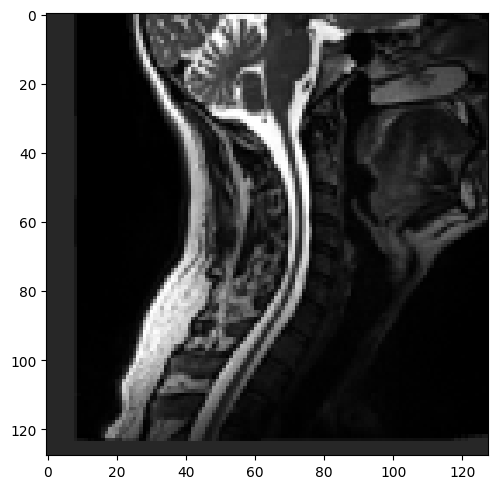

In [9]:
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass 
import nibabel as nib

with torch.no_grad():
    for batch, data in enumerate(images_loader):
        print(data['image'].shape)
        
x, y, z = 50, 50, 50

print(x, y, z)
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(np.rot90(data['image'][0][0][30,:,:]), cmap='gray')

print(torch.mean(data['image'][0][0]))
plt.tight_layout()

In [10]:
import nibabel as nib
import numpy as np
import os
import os.path as osp
from monai.inferers import SimpleInferer

device = torch.device("cuda")

root_dir = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/models/'
norm_model.load_state_dict(torch.load(
    os.path.join(root_dir, "normalization_model_1000e_registered.pt")))
segmenter.load_state_dict(torch.load(
    os.path.join(root_dir, "segmenter_model_1000e_registered.pt")))
# segmenter.load_state_dict(torch.load(
#     os.path.join(root_dir, "segmenter_model_only_1channel_800e_Reg.pt")))

norm_model.to(device)
norm_model.eval()
segmenter.to(device)
segmenter.eval()

print(list(norm_model.parameters())[0][0][0][0])
print(list(segmenter.parameters())[0][0][0][0])

save_root = '/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/predictions'

if not osp.exists(save_root):
    os.makedirs(save_root)
    
def linear_transform(input, scale):
    return input * scale 

with torch.no_grad():
    for ii,i in enumerate(images_loader):
        original_affine = i["image_meta_dict"]["affine"][0].numpy()
        name = os.path.split(images[ii])[1]
        print(os.path.split(images[ii]))
        input = (i["image"]).to(device)
        input = norm_model(input)
        i['pred'] = segmenter(input)[0] 
        i['image'] = i['image'][0] 
        i = pre_transforms.inverse(i)

        for t in test_post_transforms:
            tname = type(t).__name__
            i = t(i)

        nib.save(
                nib.Nifti1Image(i['pred'].astype(np.uint8), original_affine), os.path.join(save_root,'NormSegmenter_registered_1000e_'+name))

tensor([[ 0.1132,  0.0557, -0.0109],
        [-0.1520,  0.1794, -0.0569],
        [-0.1033,  0.0046, -0.0020]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[ 0.5593,  0.3087,  0.4558],
        [ 0.4871,  0.0313, -0.5031],
        [-0.3535, -0.1915, -0.4823]], device='cuda:0',
       grad_fn=<SelectBackward0>)
('/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/registered_dataset/images', 'sub-009_ses-01_run-1_T2w_BeLong_image_rigid_registered_to_template_Warped.nii.gz')
('/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/registered_dataset/images', 'sub-013_ses-01_run-1_T2w_BeLong_image_rigid_registered_to_template_Warped.nii.gz')
('/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/registered_dataset/images', 'sub-014_ses-01_run-1_T2w_BeLong_image_rigid_registered_to_template_Warped.nii.gz')
('/scratch/qbi/uqfribe1/postdoc/TTA_tongueseg/registered_dataset/images', 'sub-015_ses-01_run-1_T2w_BeLong_image_rigid_registered_to_template_Warped.nii.gz')
('/scratch/qbi/uqfribe1/postdoc/TTA_tongue

In [20]:
print(list(norm_model.parameters())[0][0][0][0])
print(list(segmenter.parameters())[0][0][0][0])

tensor([[ 0.1132,  0.0557, -0.0109],
        [-0.1520,  0.1794, -0.0569],
        [-0.1033,  0.0046, -0.0020]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[ 0.5593,  0.3087,  0.4558],
        [ 0.4871,  0.0313, -0.5031],
        [-0.3535, -0.1915, -0.4823]], device='cuda:0',
       grad_fn=<SelectBackward0>)


(1, 1, 64, 128, 128)
50 50 50
-0.38721392


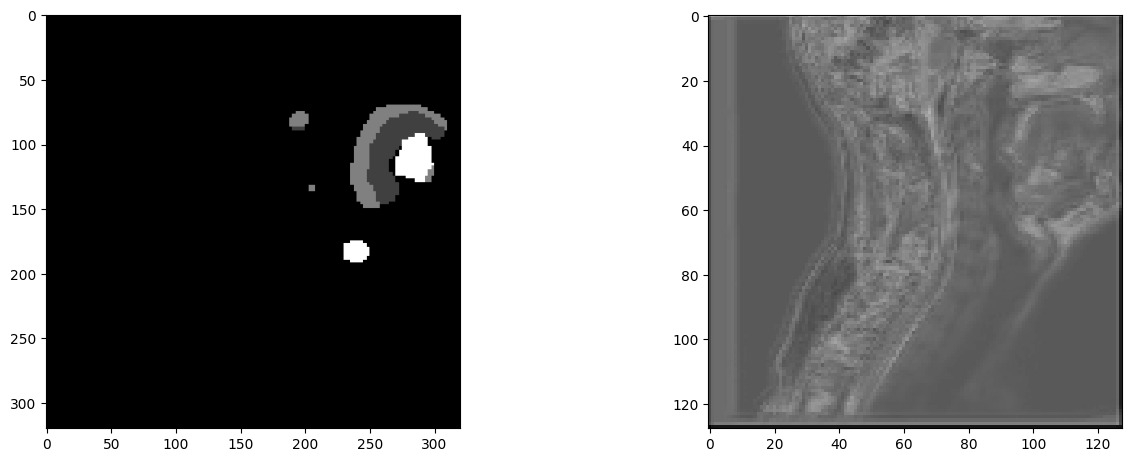

In [11]:
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass 
import nibabel as nib


x, y, z = 50, 50, 50
print(input.shape)
# print(i['pred'].shape)
print(x, y, z)
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(np.rot90(input[0][0][30,:,:].to('cpu')), cmap='gray',vmax=1)

print(np.min(input[0][0][20,:,:]))
ax2 = fig.add_subplot(1,2,1)
ax2.imshow(np.rot90(i['pred'][30,:,:]), cmap='gray')
plt.tight_layout()
